### Plant Disease Detection Using CNN

Import Libraries

In [2]:
!pip install visualkeras
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import visualkeras
from PIL import ImageFont

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 9.3 MB/s 


Setting the Global variables for comfortability

In [3]:
# Image_size variable you want use it for the kind of size of the image you wanted from the dataset.
Image_Size = 256
# Batch Size is used to take at data in the form of batches as mentioned below our code will take 32 images at a time.
Batch_Size = 32
# The channels is used for as we have RGB images we set the Channels value to 3.
Channels = 3
# The number of epochs is the number of rounds performed to train the model.
Epochs = 50

Mounting google drive to colab

In [4]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


Getting all the data with help of tensorflow

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/drive/MyDrive/Colab Notebooks/PlantVillage/", batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True) 

Found 54305 files belonging to 38 classes.


Classes Present in the Dataset

In [6]:
class_name = dataset.class_names

In [7]:
print(class_name) #There are 38 classes in the directory you will be able to see all of those listed in a list

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

Shows length of dataset per batch

In [8]:
print(len(dataset))

1698


The number shown above will confuse you but if you multiply **1698 x [batchsize] i.e 32** then we will be able to get the value i.e. **54336** and our data is have **54305** the last batch will have less images

In [9]:
print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Plotting a Batch

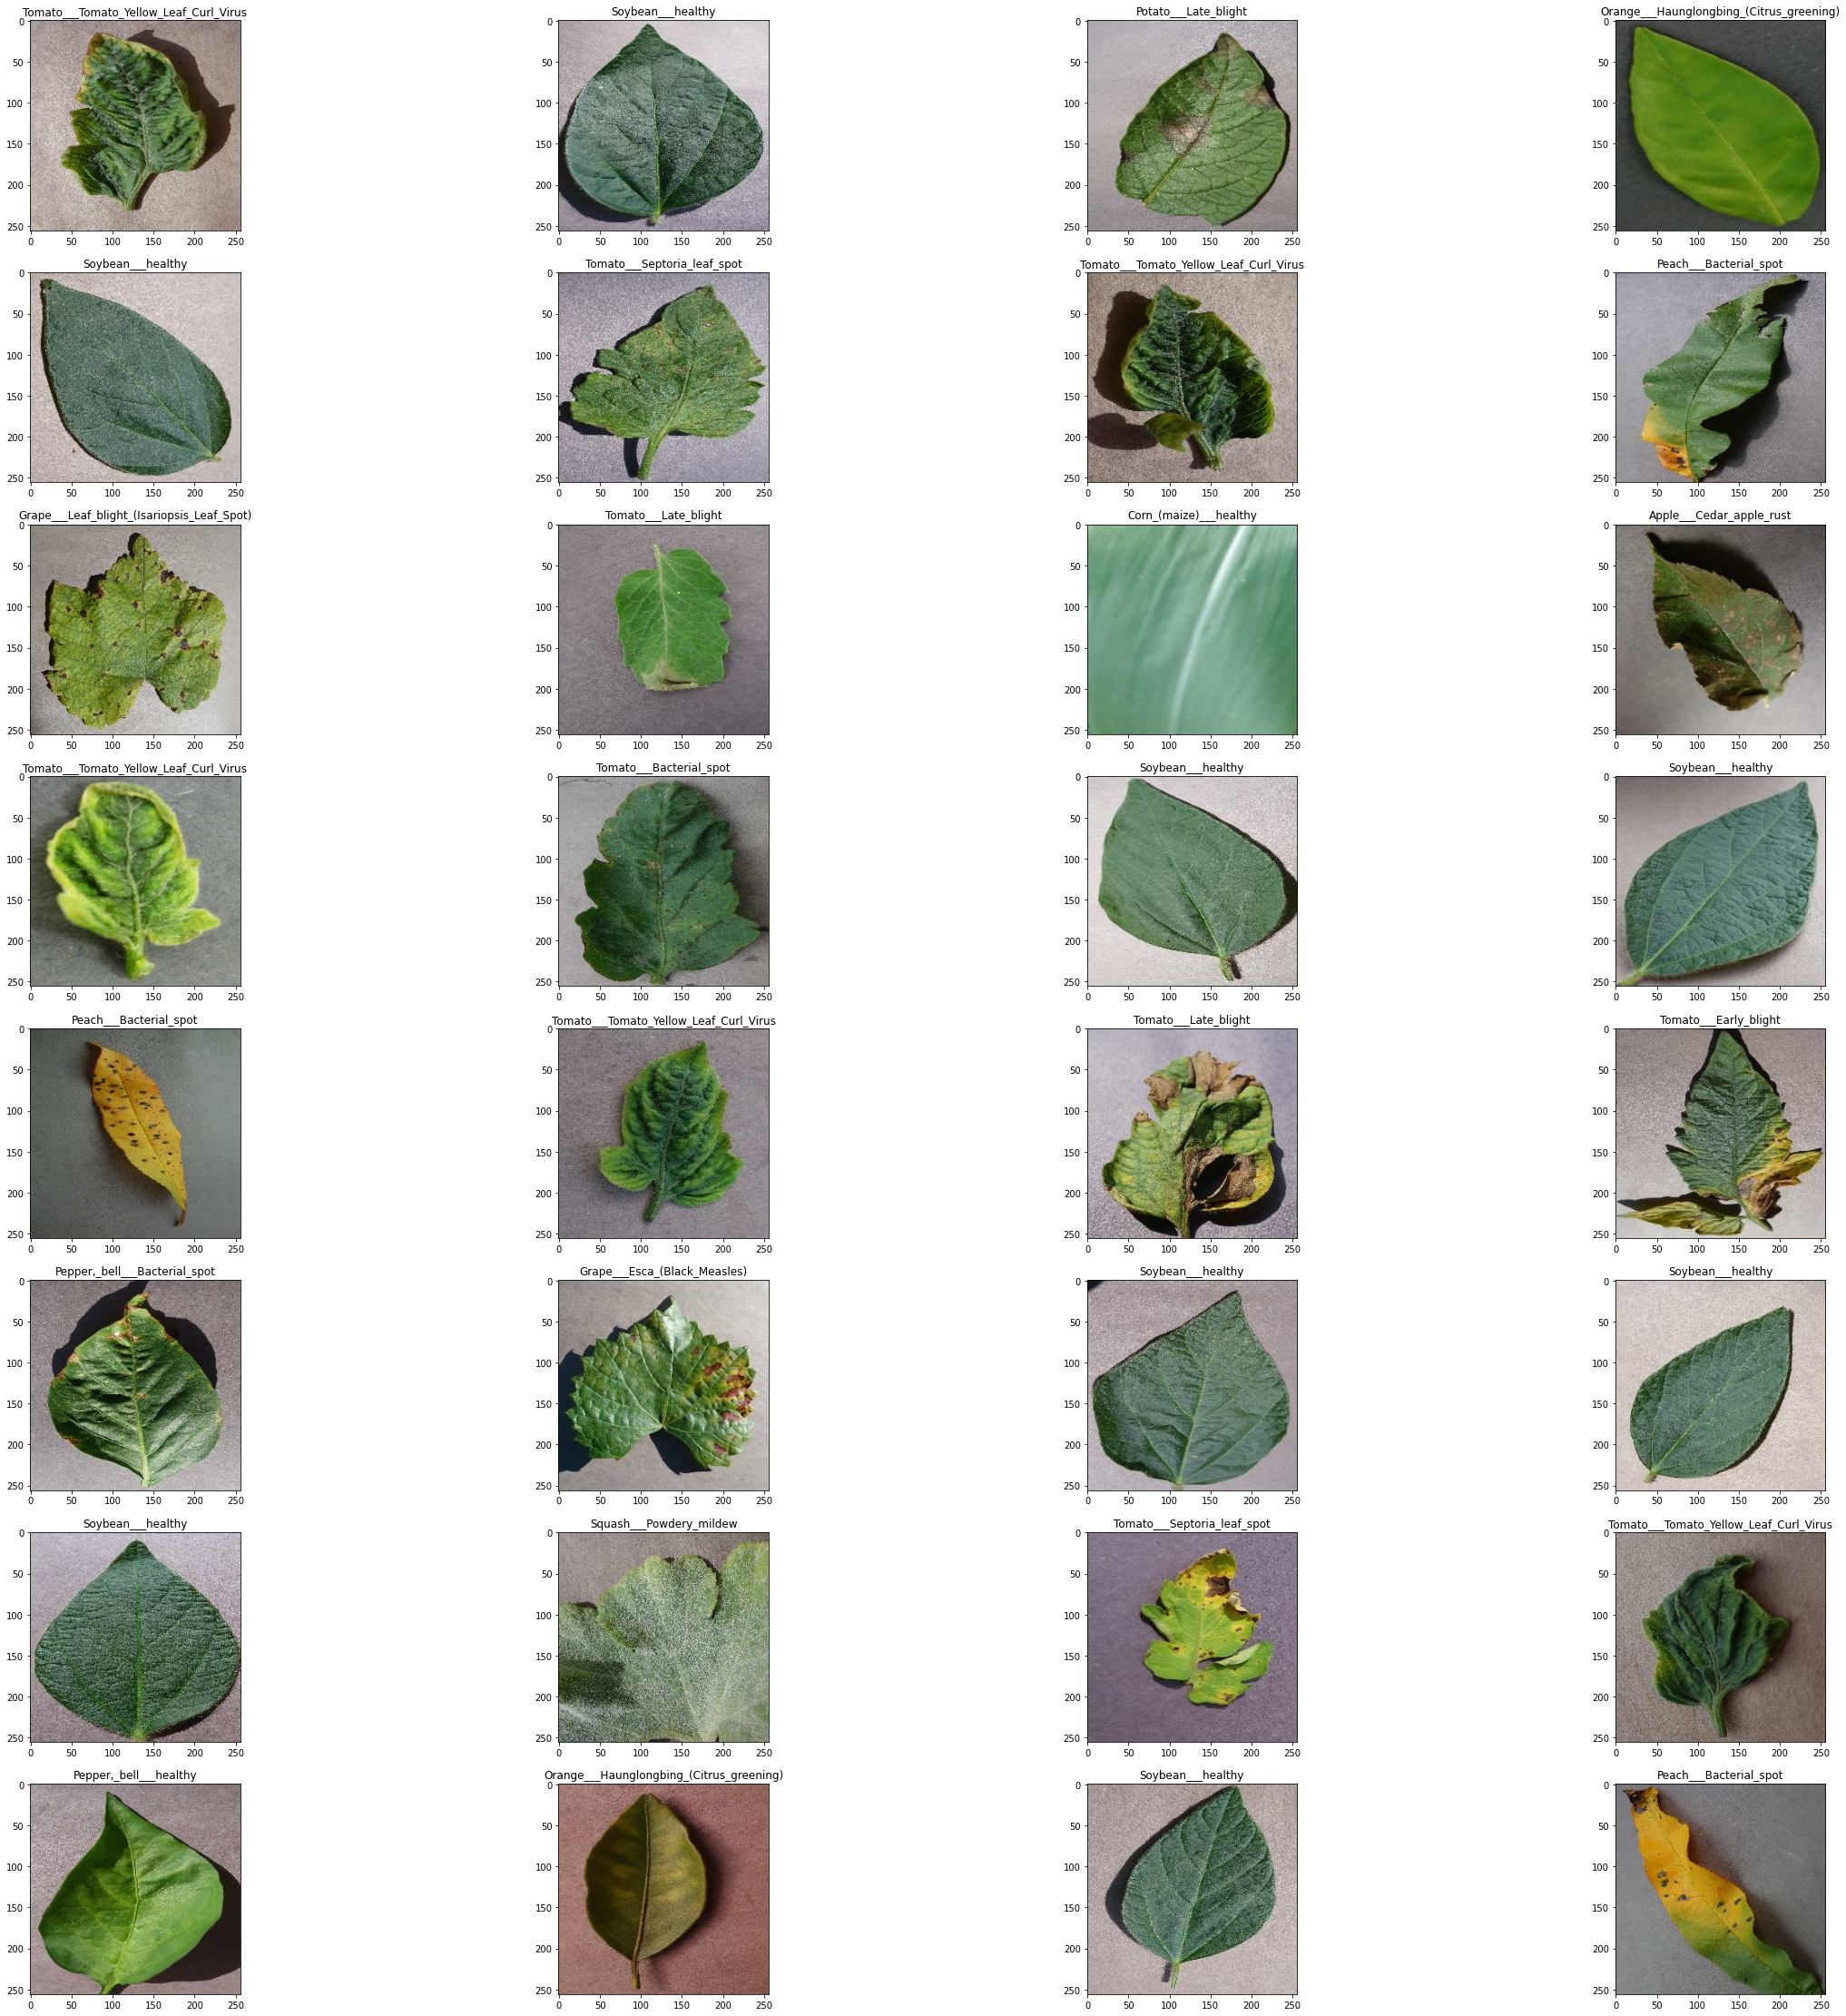

In [15]:
plt.figure(figsize = (40,40))
for image, label in dataset.take(1): 
    for i in range(32):
        plt.subplot(8,4, i+1) # produces subpolots
        plt.imshow(image[i].numpy().astype('uint8')) # conversion of data values from float to integer using numpy.
        plt.title(class_name[label[i]])

Function for splitting the data in to Training Testing and Validation Data 

In [16]:
def train_test_val_split(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):# we are using 80 10 10 train val test respectively
    
    if shuffle:
        data = data.shuffle(shuffle_size, seed = 10)
        
    dataset_size = len(data)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_dataset = data.take(train_size)
    val_dataset = data.skip(train_size).take(val_size)
    test_dataset = data.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [17]:
train_data, val_data, test_data = train_test_val_split(dataset)

In [19]:
print("Data Size :{0} \nBatch size for Training Data is :{1}\nBatch size for Testing Data is :{2}\nBatch size for Validation Data is :{3} " .format(len(dataset), len(train_data), len(test_data), len(val_data)))

Data Size :1698 
Batch size for Training Data is :1358
Batch size for Testing Data is :171
Batch size for Validation Data is :169 


As Prefetching for datasets overlaps preprocessing and model execution

In [20]:
train_dataset = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

If the image values are different the we Normalize the data By making all the images of same sizes and Rescaling it to bring all the value in between 0 and 1 

In [21]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

We tried using our model without data augmentation it is generating low accuracy and because of which we did data augmentation so that the classes which have less images will get trained properly and that helped us achive better results

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

Our CNN Architecture

In [23]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])

In [24]:
model.build(input_shape = input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

Visualization of Architecture

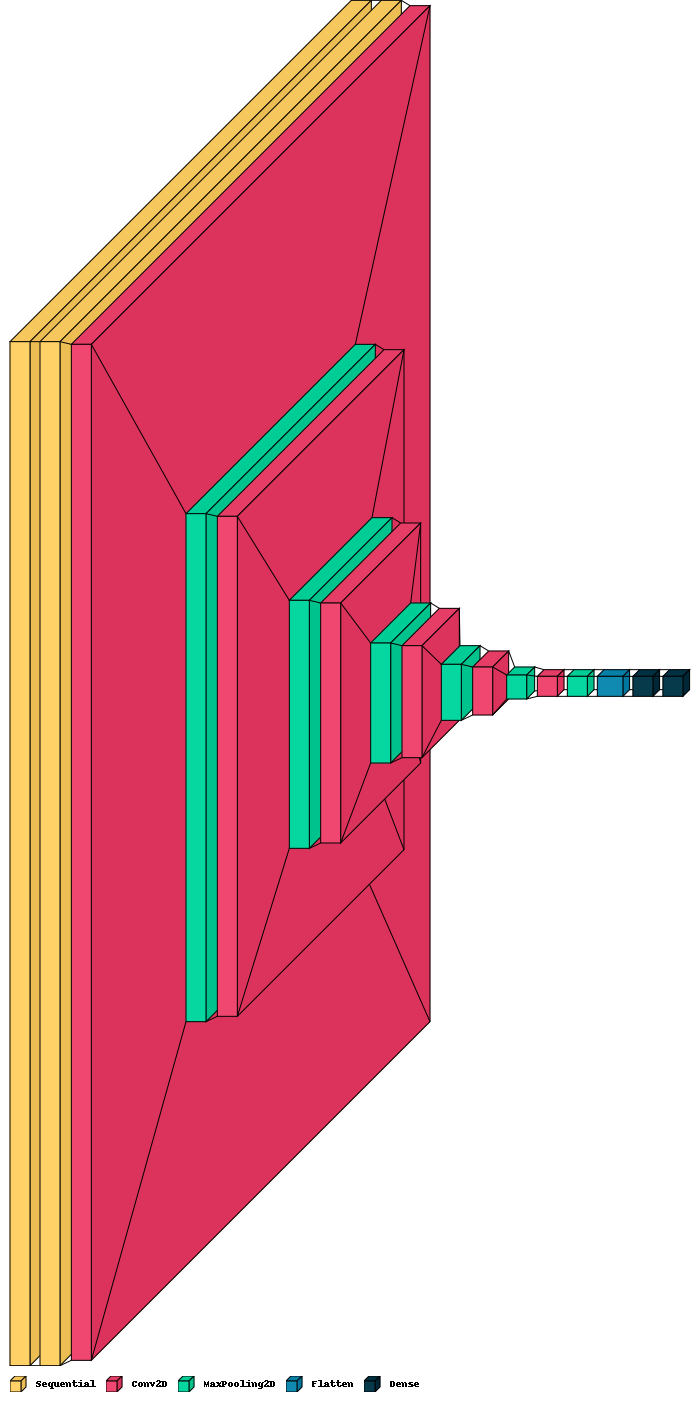

In [26]:
visualkeras.layered_view(model, legend=True)

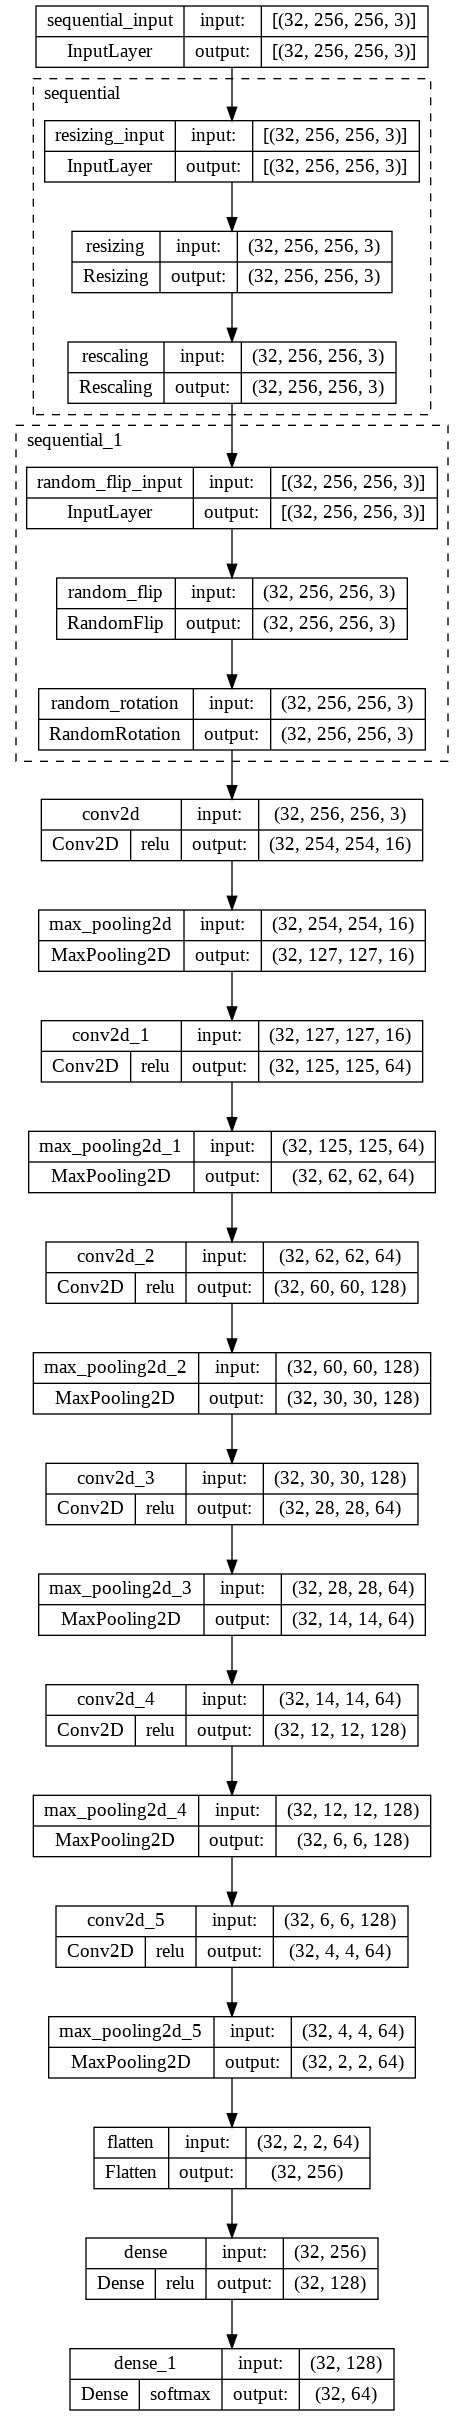

In [27]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

In [28]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

Run the Model

In [ ]:
model_history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 'auto', validation_data = val_data)

Epoch 1/50
1358/1358 [==============================] - 1387s 54ms/step - loss: 2.1514 - accuracy: 0.4061 - val_loss: 1.9357 - val_accuracy: 0.4908
Epoch 2/50
1358/1358 [==============================] - 98s 54ms/step - loss: 1.0740 - accuracy: 0.6717 - val_loss: 1.0967 - val_accuracy: 0.6753
Epoch 3/50
1358/1358 [==============================] - 99s 55ms/step - loss: 0.7140 - accuracy: 0.7711 - val_loss: 0.7584 - val_accuracy: 0.7676
Epoch 4/50
1358/1358 [==============================] - 98s 54ms/step - loss: 0.5582 - accuracy: 0.8191 - val_loss: 0.6974 - val_accuracy: 0.7831
Epoch 5/50
1358/1358 [==============================] - 99s 55ms/step - loss: 0.4507 - accuracy: 0.8534 - val_loss: 0.5663 - val_accuracy: 0.8201
Epoch 6/50
1358/1358 [==============================] - 98s 54ms/step - loss: 0.3821 - accuracy: 0.8745 - val_loss: 0.5538 - val_accuracy: 0.8243
Epoch 7/50
1358/1358 [==============================] - 98s 54ms/step - loss: 0.3427 - accuracy: 0.8867 - val_loss: 0.3395

Evaluation of the model

In [ ]:
model_evaluation_scores = model.evaluate(train_data)

1358/1358 [==============================] - 39s 11ms/step - loss: 0.1147 - accuracy: 0.9632


In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
train_loss = model_history.history['loss']
train_acc = model_history.history['accuracy']

val_loss = model_history.history['val_loss']
val_acc = model_history.history['val_accuracy']

Evaluation Plot

Text(0.5, 1.0, 'Training and Validation Loss')

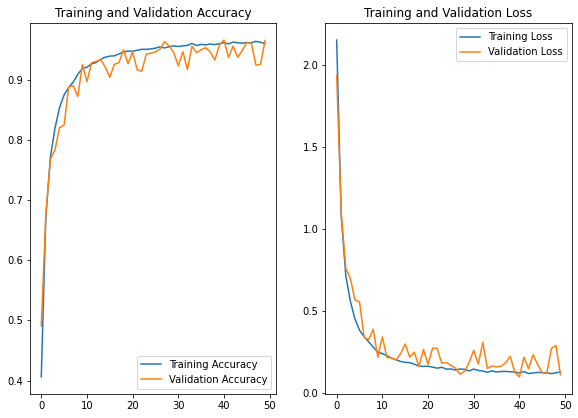

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(50), train_acc, label = 'Training Accuracy')
plt.plot(range(50), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(50), train_loss, label = 'Training Loss')
plt.plot(range(50), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Cherry_(including_sour)___healthy
1/1 [==============================] - 0s 178ms/step
Predicted label :  Cherry_(including_sour)___healthy


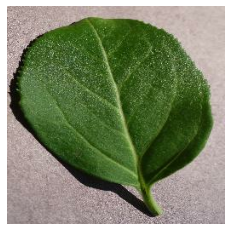

In [ ]:
for image, label in train_data.take(1):
    temp_image = image[0].numpy().astype('uint8')
    temp_label = class_name[label[0]]
    
    print('Image of batch to predict :')
    plt.imshow(temp_image)
    print('Actual label : ', temp_label)
    
    batch_prediction = model.predict(image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 [==============================] - 0s 29ms/step


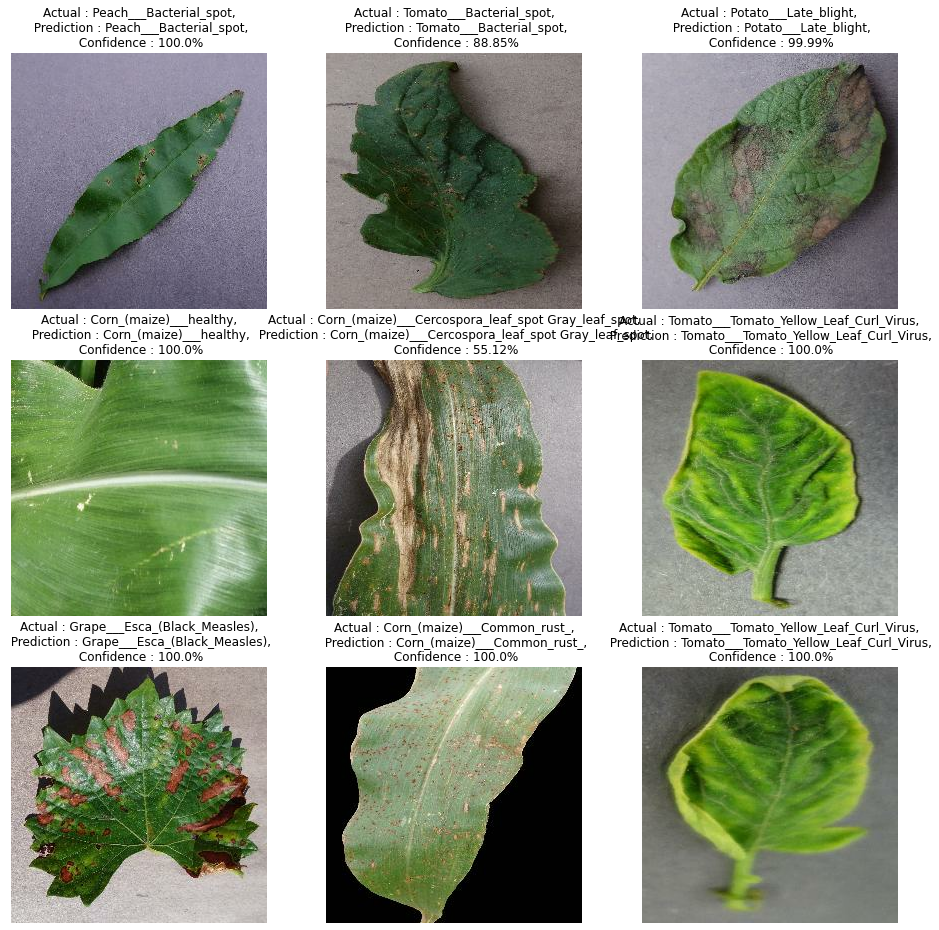

In [ ]:
plt.figure(figsize = (20,20))
for image, label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = image[i].numpy().astype('uint8')
        label = class_name[label[i]]
    
        plt.imshow(image)
    
        prediction_for_batch = model.predict(image)
        predicted_class = class_name[np.argmax(prediction_for_batch[i])]
        confidence = round(np.max(prediction_for_batch[i]) * 100, 2)
        
        plt.title(f'Actual Predicted : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    

Saving Model

In [ ]:
!mkdir -p saved_model
model.save('saved_model/plant_disease_healthy_model')